In [1]:
import torch
import math
import operator as op

def pure_hashmap_update(d, k, v):
    if isinstance(k, torch.Tensor):
        k = k.item()
    d2 = d.copy()
    d2.update({k:v})
    return d2

# got a tip from Masoud on this
def vector_list_creation(args):
    try:
        return torch.stack(args)
    except:
        return args

def mat_transpose(args):
    if isinstance(args, tuple):
        if len(args) == 1:
            args = args[0]
        else:
            assert False, "Multi-element tuple???"
    try:
        return args.t()
    except:
        assert False, "whoops"

def mat_repmat(t, i1, i2):
    return t.repeat(i1.long().item(), i2.long().item())

# inspired by https://norvig.com/lispy.html
def eval_env():
    env = {}
    env.update({
        '+': torch.add,
        '-': torch.sub,
        '*': torch.mul,
        '/': torch.div,
        '>': torch.gt,
        '<': torch.lt,
        '>=': torch.ge,
        '<=': torch.le, 
        '=': torch.eq,
        'sqrt': torch.sqrt,
        'exp': torch.exp,
        'mat-tanh': torch.tanh,
        'mat-add': torch.add,
        'mat-mul': torch.matmul,
        'mat-repmat': mat_repmat,
        'mat-transpose': lambda *x: mat_transpose(x),
        'vector': lambda *x: vector_list_creation(x),
        'hash-map': lambda *x : dict(zip([i.item() if isinstance(i, torch.Tensor) else i for i in x[::2]], x[1::2])),
        'get': lambda x, y: x[y.long()] if isinstance(x, torch.Tensor) else x[y.item() if isinstance(y, torch.Tensor) else y],
        'put': lambda x, y, z: torch.cat((x[:y.long()], torch.tensor([z]), x[y.long()+1:])) if isinstance(x, torch.Tensor) else pure_hashmap_update(x,y,z),
        'append' : lambda x, y: torch.cat((x, torch.tensor([y]))),
        'first' : lambda x: x[0],
        'second': lambda x: x[1],
        'rest': lambda x: x[1:],
        'last' : lambda x: x[-1],
        'remove': lambda x, y : torch.cat((x[:y.long()], x[y.long()+1:])) if isinstance(x, torch.Tensor) else {i:x[i] for i in x if i != y},
        'normal': torch.distributions.Normal,
        'beta': torch.distributions.beta.Beta,
        'exponential': torch.distributions.exponential.Exponential,
        'uniform': torch.distributions.uniform.Uniform,
        'bernoulli': torch.distributions.bernoulli.Bernoulli,
        'discrete': lambda *x: torch.distributions.categorical.Categorical(x[0]) 
        })


    return env

In [2]:
from daphne import daphne
from tests import is_tol, run_prob_test,load_truth
from primitives import eval_env
import torch

ENV = None

def evaluate_program(ast, return_sig=False):
    """Evaluate a program as desugared by daphne, generate a sample from the prior
    Args:
        ast: json FOPPL program
    Returns: sample from the prior of ast
    """
    global ENV
    ENV = eval_env()
    for defn in ast[:-1]:
        f_name = defn[1]
        f_v_is = defn[2]
        f_expr = defn[3]
        ENV.update({f_name: (f_v_is, f_expr)})
    l = {}
    ret, sig = evaluate(ast[-1], l)
    return (ret, sig) if return_sig else ret

# inspired by https://norvig.com/lispy.html
def evaluate(e, l, sig=None):
    # variable reference OR procedure OR just a string
    if isinstance(e, str):        
        # global procedures take precedence over locally defined vars
        if e in ENV:
            return ENV[e], sig
        elif e in l:
            return l[e], sig
        # allows for hashmaps with string keys; for debugging setting this to fail
        else:
            assert False, "Unknown symbol: {}".format(e)
            return e
    # constant number
    elif isinstance(e, (int, float)):   
        return torch.tensor(float(e)), sig
    # if statements
    elif e[0] == 'if':
        (_, test, conseq, alt) = e
        exp = (conseq if evaluate(test, l)[0] else alt)
        return evaluate(exp, l)
    # let statements
    elif e[0] == 'let':
        # get symbol
        symbol = e[1][0]
        # get value of e1
        value, _ = evaluate(e[1][1], l)
        # evaluate e2 with value 
        return evaluate(e[2], {**l, symbol: value})
    # sample statement
    if e[0] == 'sample':
        dist = evaluate(e[1], l)[0]
        # make sure it is a distribution object
        assert getattr(dist, '__module__', None).split('.')[:2] == ['torch', 'distributions']
        return dist.sample(), sig
    # obsere statements
    # TODO: change this, maybe in this hw or for hw3
    if e[0] == 'observe':
        dist = evaluate(e[1], l)[0] # get dist
        y = evaluate(e[2], l)[0]    # get observed value
        # make sure it is a distribution object
        assert getattr(dist, '__module__', None).split('.')[:2] == ['torch', 'distributions']
        # TODO: do something with observed value
        return dist.sample(), sig
    # procedure call, either primitive or user-defined
    else:
        result = evaluate(e[0], l)
        proc, sig = result
        # primitives are functions
        if callable(proc):
            args = [evaluate(arg, l)[0] for arg in e[1:]]
            result, sig = proc(*args), sig
            return result, sig
        # user defined functions are not
        else:
            # as written in algorithm 6
            v_is, e0 = proc 
            assert(len(v_is) == len(e[1:]))
            c_is = [evaluate(arg, l)[0] for arg in e[1:]]
            l_proc = dict(zip(v_is, c_is))
            return evaluate(e0, {**l, **l_proc})

# Program 1

In [30]:
i = 1
ast = daphne(['desugar', '-i', '../CS532-HW2/programs/{}.daphne'.format(i)])

In [31]:
print(evaluate_program(ast, return_sig=True)[0])

tensor(1.5666)


In [32]:
import numpy as np
import matplotlib.pyplot as plt

In [33]:
results_1 = np.zeros(1000)

for i in range(1000):
    results_1[i] = evaluate_program(ast, return_sig=True)[0].item()

Text(0.5, 1.0, 'Gaussian Unknown Mean Problem (Evaluation-Based)')

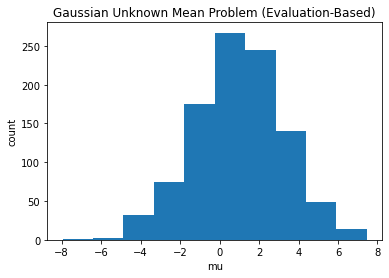

In [34]:
plt.hist(results_1)
plt.xlabel('mu')
plt.ylabel('count')
plt.title('Gaussian Unknown Mean Problem (Evaluation-Based)')

In [35]:
print(np.mean(results_1))

0.9831181299090386


# Program 2

In [36]:
i=2
ast = daphne(['desugar', '-i', '../CS532-HW2/programs/{}.daphne'.format(i)])

In [37]:
print(evaluate_program(ast, return_sig=True)[0])

tensor([  4.4539, -14.5233])


In [38]:
results_2 = np.zeros((1000,2))

for i in range(1000):
    results_2[i] = evaluate_program(ast, return_sig=True)[0].numpy()

In [39]:
results_2

array([[ -7.07100964,  -5.16104937],
       [ 15.34262562,  10.90234756],
       [  6.7403059 ,  -1.3948431 ],
       ...,
       [  0.84671026,  -2.00265455],
       [  2.33683586,  -1.21618056],
       [  9.04983139, -15.97388744]])

Text(0.5, 1.0, 'Bayesian Linear Regression Problem (slope) (Evaluation-Based)')

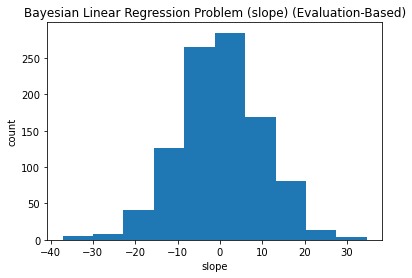

In [96]:
plt.hist(results_2[:, 0])
plt.xlabel('slope')
plt.ylabel('count')
plt.title('Bayesian Linear Regression Problem (slope) (Evaluation-Based)')

Text(0.5, 1.0, 'Bayesian Linear Regression Problem (bias) (Evaluation-Based)')

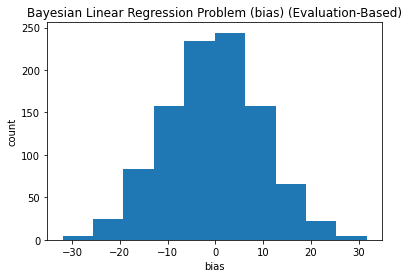

In [95]:
plt.hist(results_2[:, 1])
plt.xlabel('bias')
plt.ylabel('count')
plt.title('Bayesian Linear Regression Problem (bias) (Evaluation-Based)')

In [42]:
np.mean(results_2, axis=0)

array([-0.01206526, -0.26044796])

# Program 3

In [43]:
i=3
ast = daphne(['desugar', '-i', '../CS532-HW2/programs/{}.daphne'.format(i)])

In [44]:
print(evaluate_program(ast, return_sig=True)[0])

tensor([2, 1, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 1, 2, 2, 2, 1])


In [45]:
results_3 = np.zeros((1000,17))
for i in range(1000):
    results_3[i] = evaluate_program(ast, return_sig=True)[0].numpy()

In [46]:
results_3

array([[1., 0., 1., ..., 0., 2., 2.],
       [2., 2., 2., ..., 2., 2., 1.],
       [2., 1., 2., ..., 2., 2., 2.],
       ...,
       [0., 0., 2., ..., 1., 0., 2.],
       [1., 2., 0., ..., 2., 1., 0.],
       [0., 2., 2., ..., 2., 2., 1.]])

Text(0.5, 1.0, 'Hidden Markov Model (dim 0) (Evaluation-Based)')

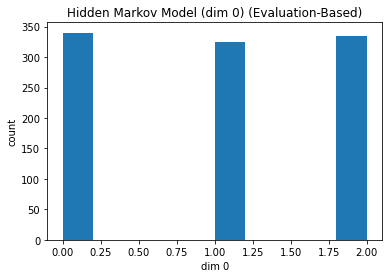

In [94]:
i = 0
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 1) (Evaluation-Based)')

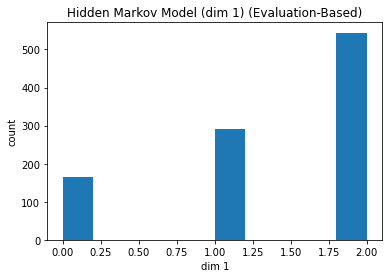

In [93]:
i = 1
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 2) (Evaluation-Based)')

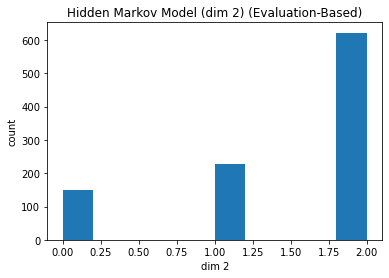

In [92]:
i = 2
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 3) (Evaluation-Based)')

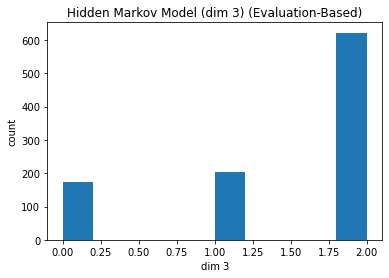

In [91]:
i = 3
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 4) (Evaluation-Based)')

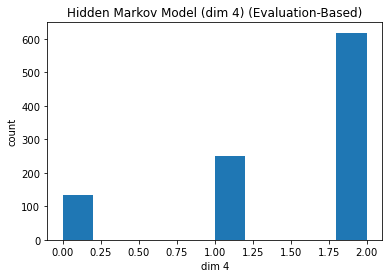

In [90]:
i = 4
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 5) (Evaluation-Based)')

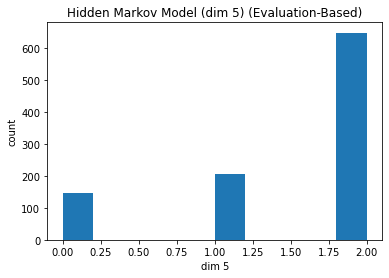

In [89]:
i = 5
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 6) (Evaluation-Based)')

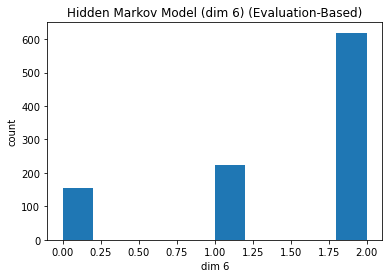

In [88]:
i = 6
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 7) (Evaluation-Based)')

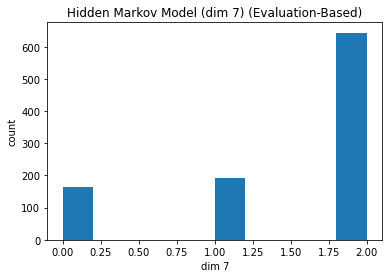

In [87]:
i = 7
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 8) (Evaluation-Based)')

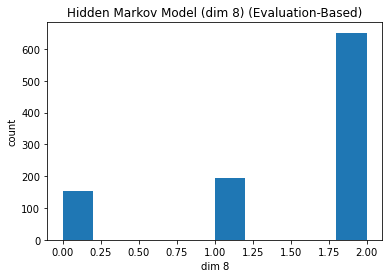

In [86]:
i = 8
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 9) (Evaluation-Based)')

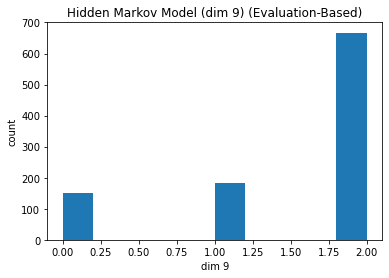

In [85]:
i = 9
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 10) (Evaluation-Based)')

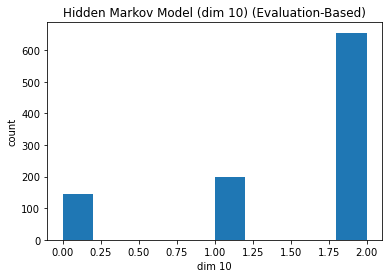

In [84]:
i = 10
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 11) (Evaluation-Based)')

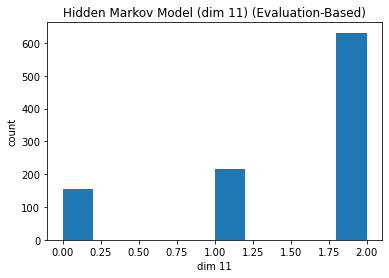

In [83]:
i = 11
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 12) (Evaluation-Based)')

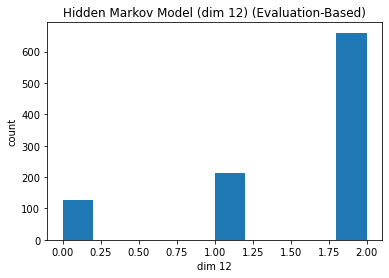

In [82]:
i = 12
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 13) (Evaluation-Based)')

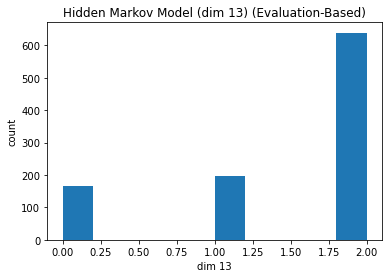

In [81]:
i = 13
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 14) (Evaluation-Based)')

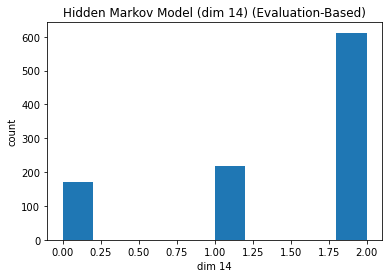

In [80]:
i = 14
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 15) (Evaluation-Based)')

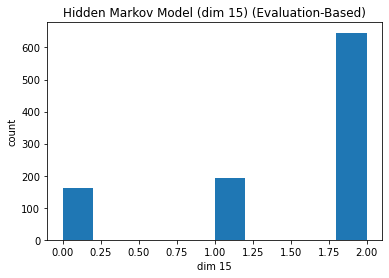

In [78]:
i = 15
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

Text(0.5, 1.0, 'Hidden Markov Model (dim 16) (Evaluation-Based)')

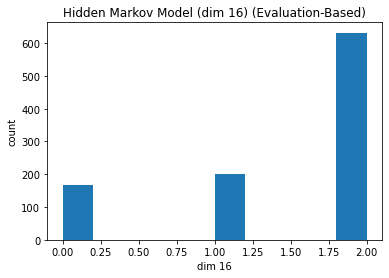

In [79]:
i = 16
plt.hist(results_3[:, i])
plt.xlabel('dim {}'.format(i))
plt.ylabel('count')
plt.title('Hidden Markov Model (dim {}) (Evaluation-Based)'.format(i))

In [64]:
np.mean(results_3, axis=0)

array([0.995, 1.378, 1.472, 1.447, 1.485, 1.5  , 1.463, 1.48 , 1.497,
       1.517, 1.509, 1.477, 1.532, 1.474, 1.442, 1.485, 1.466])

# Program 4

In [66]:
i=4
ast = daphne(['desugar', '-i', '../CS532-HW2/programs/{}.daphne'.format(i)])

In [67]:
print(evaluate_program(ast, return_sig=True)[0])

(tensor([[ 1.4141],
        [ 0.8765],
        [ 0.5880],
        [-1.5198],
        [-0.8073],
        [-1.2833],
        [ 1.4462],
        [-0.1839],
        [-0.3833],
        [-0.0150]]), tensor([[-0.3743],
        [ 1.1586],
        [ 0.2057],
        [-1.0828],
        [ 0.3008],
        [ 0.8869],
        [-1.1427],
        [ 1.1455],
        [ 0.3590],
        [ 0.9784]]), tensor([[-0.1504,  0.7666,  0.1019, -0.5412, -0.0961,  0.8524, -0.6334, -0.6001,
         -1.2728, -0.1771],
        [-2.4504, -0.3162,  0.0251, -1.0948, -0.7497, -0.0839,  0.9000,  0.6104,
         -0.6337, -1.5308],
        [-1.2708, -0.7771, -0.0921,  1.0128,  0.4595, -0.1219, -0.2020,  0.1243,
         -0.7990, -0.3741],
        [ 0.6316, -1.0369, -0.0932, -0.1861,  0.4731, -0.5760,  0.8886,  1.3612,
         -0.3560, -0.6627],
        [ 0.7172, -0.7923,  0.8389, -0.8088,  0.6562,  0.4158,  0.5689,  1.4741,
         -2.5236, -1.6590],
        [ 1.7362,  1.0949, -1.1764, -0.7614, -1.2545, -0.8786,  0.1211

In [74]:
test=evaluate_program(ast, return_sig=True)[0]
print(test[0].flatten().size())
print(test[1].flatten().size())
print(test[2].flatten().size())
print(test[3].flatten().size())

torch.Size([10])
torch.Size([10])
torch.Size([100])
torch.Size([10])


In [75]:
results_4_1 = np.zeros((1000, 10))
results_4_2 = np.zeros((1000, 10))
results_4_3 = np.zeros((1000, 100))
results_4_4 = np.zeros((1000, 10))

for i in range(1000):
    result = evaluate_program(ast, return_sig=True)[0]
    results_4_1[i] = result[0].flatten().numpy()
    results_4_2[i] = result[1].flatten().numpy()
    results_4_3[i] = result[2].flatten().numpy()
    results_4_4[i] = result[3].flatten().numpy()

Text(0.5, 1.0, 'Bayesian Neural Network (W0, dim0) (Evaluation-Based)')

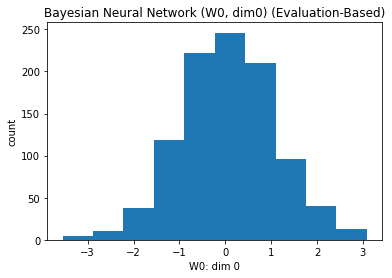

In [77]:
i = 0
plt.hist(results_4_1[:, i])
plt.xlabel('W0: dim {}'.format(i))
plt.ylabel('count')
plt.title('Bayesian Neural Network (W0, dim0) (Evaluation-Based)')

Text(0.5, 1.0, 'Bayesian Neural Network (b0, dim0) (Evaluation-Based)')

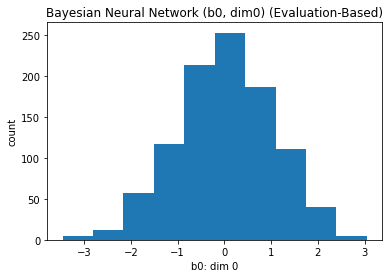

In [97]:
i = 0
plt.hist(results_4_2[:, i])
plt.xlabel('b0: dim {}'.format(i))
plt.ylabel('count')
plt.title('Bayesian Neural Network (b0, dim0) (Evaluation-Based)')

Text(0.5, 1.0, 'Bayesian Neural Network (W1, dim0) (Evaluation-Based)')

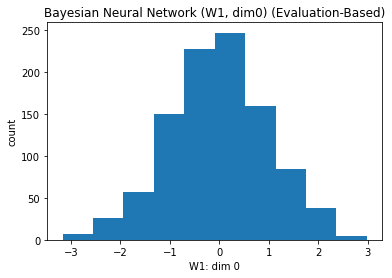

In [98]:
i = 0
plt.hist(results_4_3[:, i])
plt.xlabel('W1: dim {}'.format(i))
plt.ylabel('count')
plt.title('Bayesian Neural Network (W1, dim0) (Evaluation-Based)')

Text(0.5, 1.0, 'Bayesian Neural Network (b1, dim0) (Evaluation-Based)')

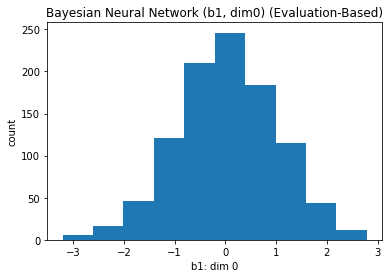

In [99]:
i = 0
plt.hist(results_4_4[:, i])
plt.xlabel('b1: dim {}'.format(i))
plt.ylabel('count')
plt.title('Bayesian Neural Network (b1, dim0) (Evaluation-Based)')

In [100]:
np.mean(results_4_1, axis=0)

array([ 0.06210016, -0.0124073 ,  0.02690243, -0.02579805, -0.00581487,
        0.0249348 ,  0.00161231,  0.00578257,  0.0058268 , -0.01553683])

In [101]:
np.mean(results_4_2, axis=0)

array([ 2.69428645e-02, -2.90134809e-02,  3.38031984e-02,  2.56868738e-02,
        5.49964488e-05,  4.10347368e-02, -3.63386200e-02,  4.04563448e-02,
        7.23249204e-03, -2.63176928e-02])

In [102]:
np.mean(results_4_3, axis=0)

array([-1.69434429e-02, -2.82588857e-02,  8.41523389e-03, -4.17425348e-02,
        2.59640710e-02, -1.02361627e-02, -1.57667506e-02, -2.85485419e-02,
        1.07463385e-02,  1.08434329e-02, -7.79320669e-05, -1.99428492e-02,
       -2.82253434e-02, -8.88817147e-03,  2.60452806e-03,  3.74277758e-03,
       -5.72703136e-02, -1.05878194e-02,  9.27220891e-03,  7.51811433e-02,
       -3.49123586e-02,  2.28955057e-02,  1.51579198e-02, -9.92869577e-03,
        2.42693261e-02, -5.00943136e-02, -8.63236373e-03, -3.88687168e-02,
       -8.47227844e-03,  2.06014886e-02,  1.57140502e-03,  5.44032320e-03,
       -4.72808148e-03, -6.66817055e-04, -1.71323397e-02,  4.64313448e-02,
        2.13817890e-02, -6.56111340e-02, -9.92387404e-03,  5.52050047e-02,
        1.25957220e-02, -1.95701533e-02, -6.42880902e-02,  1.50441356e-02,
        6.11960852e-03,  1.11983488e-02, -7.55744832e-04, -2.55554180e-02,
        3.23528831e-02,  7.53206097e-03, -3.07324243e-02, -1.03162070e-02,
        1.62823585e-03,  

In [105]:
np.mean(results_4_4, axis=0)

array([ 0.03871661, -0.00283617, -0.0330745 ,  0.00633988, -0.01339671,
       -0.03604239, -0.00124856,  0.01376909,  0.04508563,  0.01498971])

In [106]:
np.std(results_4_1, axis=0)

array([1.03662914, 0.9986556 , 0.99605675, 1.00445755, 1.0183881 ,
       0.97672567, 1.02351632, 1.00996519, 1.00128999, 1.0019746 ])

In [107]:
np.std(results_4_2, axis=0)

array([1.04052451, 0.98248427, 0.96876835, 1.06081871, 1.00277508,
       0.97440994, 1.01680225, 1.05082494, 1.00306972, 0.99658559])

In [108]:
np.std(results_4_3, axis=0)

array([0.98620818, 0.96579226, 1.00185973, 0.98271668, 0.96763741,
       0.99043092, 0.99633301, 1.0027085 , 1.00279904, 1.0118756 ,
       0.95720339, 0.9924322 , 1.0227718 , 1.00323677, 0.97194675,
       1.03115181, 1.0025122 , 1.00771746, 0.97943995, 1.01444232,
       1.02119408, 1.00668455, 1.0416555 , 0.9902275 , 1.02141948,
       0.989611  , 1.00500471, 1.00179032, 0.99741075, 1.00473739,
       0.97645031, 1.00764762, 1.02662359, 0.97405227, 1.03348379,
       0.99950394, 1.00828024, 1.01620557, 1.01142844, 1.00577192,
       1.00323242, 0.99991104, 1.02175569, 1.02487259, 0.98368197,
       0.95304158, 1.01179319, 0.97659899, 0.99080167, 0.96968245,
       0.98364952, 0.98441051, 0.99608548, 0.980823  , 1.00388991,
       0.95581718, 1.00212766, 0.96510007, 1.02829354, 1.00305902,
       0.99422837, 1.03201975, 1.0280412 , 1.01297216, 1.02134089,
       0.98069872, 1.0126956 , 0.97710262, 1.01814403, 1.01616897,
       0.99616565, 0.958174  , 1.00939591, 0.98508181, 1.03630

In [109]:
np.std(results_4_4, axis=0)

array([0.98374418, 1.00013264, 1.00090599, 0.98512603, 0.98987266,
       1.02615077, 0.99505858, 1.00615044, 0.99214421, 1.00153752])